# Intro

A little background story:

I decided to take part in [this kaggle competition](https://www.kaggle.com/c/nlp-getting-started/overview) predicting whether a twitter tweet signals a real disaster. After a few rounds of data cleansing + preprocessing as well as trials with various models, I realised it was difficult to improve my model performance further - my best f1 score was 0.80061 and was achieved using Multinomial Naive Bayes.

Back to this notebook, I would like to try transfer learning using PyTorch and see if it would give a good boost to the f1 score.

Before starting, I came across some good resources and would like to mention them for they helped me a lot in getting started:
1. [PyTorch Tutorial](https://pytorch.org/tutorials/intermediate/dynamic_quantization_bert_tutorial.html)
2. [BERT Fine Tuning](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
3. [PyTorch pretrained BERT](https://modelzoo.co/model/pytorch-pretrained-bert)

tl;dr:
Yes! It did improve my score. I am now at 0.82413. Not tremendous, I know, but my knowledge improved much more than my score did.

My next step is to perform some sort of data augmentation to increase the training data size. The current (also the original) training data has 7613 rows, which isn't a lot. 



# Setup

Before I begin, I would like to download [transformers](https://github.com/huggingface/transformers) package by huggingface. It's a really useful library for tokenizing and training later but Colab doesn't have it installed. So let's do that manually. 

In [0]:
!pip install transformers
# output from this cell has been omitted

In [2]:
# import all the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import random
import re
import os

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


1.15.0


It's quite amazing that Google offers GPU for free. This notebook is run on Google Colab GPU. 

In [3]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Data

I got my data from the competition page [data tab](https://www.kaggle.com/c/nlp-getting-started/data).

Usual start, pandas to read csv and get our train data in a pandas dataframe. I usually print the shape and do `head()`, `tail()` or `sample()` just to have a sense of what the data looks like. Since I have had quite a thorough look at the data beforehand, I am excluding data exploration in this notebook. 

In [4]:
# get train data
path = "/content/train.csv"
df = pd.read_csv(path)

# overview of data
print("df shape: {}".format(df.shape))
df.sample(10)

df shape: (7613, 5)


,id,keyword,location,text,target
2487,3570,desolate,"Lahti, Finland",A new favorite: Desolate 2 by r3do https://t.c...,0
6691,9586,thunder,NaN,The thunder shook my house woke my sister and ...,1
7247,10377,weapons,NaN,@kirstiealley @_AnimalAdvocate Or pay it for a...,0
4644,6603,inundated,Land of Lincoln,@yahoocare perhaps you should change you name ...,0
663,958,blaze,Mo.City,@Beautiful_Juic1 just letting you know,0
4765,6781,lightning,Elchilicitanierraversal,#NowPlaying 'The Lightning Strike' de Snow Pat...,0
1524,2204,catastrophic,Lurking,Pretty much every time the audio dies on an au...,0
7517,10750,wreckage,"Mumbai, Maharashtra",Wreckage 'Conclusively Confirmed' as From MH37...,1
2443,3508,derailment,NaN,#news Madhya Pradesh Train Derailment: Village...,1
3111,4465,electrocuted,NaN,@steveycheese99 @MapMyRun where you being elec...,0


I am performing a two-line preprocessing here. The reason for doing minimal preprocessing is to test how good BERT is, without interfering too much at initial stage. 

After a few rounds of experiments, I added a `clean()` function. It's quite an exhaustive list but I am pretty sure I will get back to it later to make it neater and more concise.

In [0]:
# some simple preprocessing
df[['keyword', 'location']] = df[['keyword', 'location']].fillna(" ")
df["tweets"] = df["text"] + " " + df["keyword"] + " " + df["location"]

In [0]:
# get our feature and target as arrays. 
tweets = df["tweets"].values
labels = df["target"].values

In [0]:
# this is quite an exhaustive list

def clean(tweet):

    tweet = tweet.lower()
    tweet = re.sub(r"https?://\S+|www\.\S+", "http", tweet)
    tweet = re.sub(r"<.*?>", "html", tweet)

    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r"", tweet)

    # special characters
    tweet = re.sub(r"\x89û_", "", tweet)
    tweet = re.sub(r"\x89ûò", "", tweet)
    tweet = re.sub(r"\x89ûó", "", tweet)
    tweet = re.sub(r"\x89ûïwhen", "when", tweet)
    tweet = re.sub(r"\x89ûï", "", tweet)
    tweet = re.sub(r"China\x89ûªs", "china's", tweet)
    tweet = re.sub(r"let\x89ûªs", "let's", tweet)
    tweet = re.sub(r"\x89û÷", "", tweet)
    tweet = re.sub(r"\x89ûª", "", tweet)
    tweet = re.sub(r"\x89û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89û¢", "", tweet)
    tweet = re.sub(r"\x89û¢åê", "", tweet)
    tweet = re.sub(r"fromåêwounds", "from wounds", tweet)
    tweet = re.sub(r"åê", "", tweet)
    tweet = re.sub(r"åè", "", tweet)
    tweet = re.sub(r"japì_n", "japan", tweet)    
    tweet = re.sub(r"ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"suruì¤", "suruc", tweet)
    tweet = re.sub(r"åç", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åà", "", tweet)

    tweet = re.sub(r",", "", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typos, slang and informal abbreviations
    tweet = re.sub(r"hwy", "highway", tweet)  
    tweet = re.sub(r"pkwy", "parkway", tweet) 
    tweet = re.sub(r"fvck", "fuck", tweet)  
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"usagov", "usa government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"ph0tos", "photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"trfc", "traffic", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet) 
    tweet = re.sub(r"2k\d\d", "20"+ tweet[2:4], tweet)
    tweet = re.sub(r"clvlnd", "cleveland", tweet)
    
    tweet = re.sub(r"t's", "t is", tweet)
    tweet = re.sub(r"n't", " not", tweet)
    tweet = re.sub(r"'ve", " have", tweet)
    return tweet

In [0]:
# apply clean() function to all tweets
tweets = [clean(tweet) for tweet in tweets]

# Getting Ready

Making our tweets BERT-ready so that BERT could read it.

In [9]:
# Load the pretrained BERT tokenizer and encode all tweets 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

input_ids = []

for tweet in tweets:
  encoded_tweet = tokenizer.encode(tweet, add_special_tokens=True)
  input_ids.append(encoded_tweet)

# display an example
print("Original tweet: {}".format(tweets[0]))
print("Token IDs: {}".format(input_ids[0]))


Original tweet: our deeds are the reason of this #earthquake may allah forgive us all    
Token IDs: [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102]


In [10]:
# Know what the max tweet length is
print('Max tweet length: ', max([len(tweet_id) for tweet_id in input_ids]))

Max tweet length:  93


In [11]:
# I created an arbitrary max_len for padding. 128 because it's the smallest (2^x) number.
max_len = 128
print("Padding all tweets to max length: {}".format(max_len))

# pad with value = 0 and behind the tweets (hence 'post')
# alternatively, could use torch.nn.utils.rnn.pad_sequence()
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', value=0,
                          truncating='post', padding='post')

Padding all tweets to max length: 128


In [0]:
# attention masks are for BERT to differentiate which are real words and which are padded sequence
# real words have IDs > 0 while paddings have IDs == 0
# the attention masks should be 0 for padded sequence and 1 for real words

attention_masks = []

for encoded_tweet in input_ids:
    att_mask = [int(token_id > 0) for token_id in encoded_tweet]

    attention_masks.append(att_mask)
    

In [0]:
# Splitting data: 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = \
        train_test_split(input_ids, labels, random_state=1729, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = \
        train_test_split(attention_masks, labels, random_state=1729, test_size=0.2)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Model and Methods

In [16]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification 
# layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # 2 for binary classification  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

This [post](https://towardsdatascience.com/why-adamw-matters-736223f31b5d) explains quite well the difference between Adam and AdamW. It seems that AdamW performs better than the classic Adam optimizer. So I will use it here. 

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

I have decided to use `epochs = 5` even though the recommended numbers are between 2 and 4. This is because I realised there was still room for improvement at the 4th epoch. If you scroll down to look at the graph for losses, you could tell that at the 5th epoch, the loss is less than that at the 4th epoch. 

In [0]:
# Number of training epochs
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Helper Functions

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format elapsed time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training

The following training code is based on the `run_glue.py` script from huggingface, click [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128) for source.

In [20]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, 
                                                                        len(train_dataloader), 
                                                                        elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:51.
  Batch    80  of    191.    Elapsed: 0:01:43.
  Batch   120  of    191.    Elapsed: 0:02:34.
  Batch   160  of    191.    Elapsed: 0:03:26.

  Average training loss: 0.4507
  Training epcoh took: 0:04:05

Running Validation...
  Accuracy: 0.8112
  Validation took: 0:00:21

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:51.
  Batch    80  of    191.    Elapsed: 0:01:43.
  Batch   120  of    191.    Elapsed: 0:02:34.
  Batch   160  of    191.    Elapsed: 0:03:25.

  Average training loss: 0.3228
  Training epcoh took: 0:04:04

Running Validation...
  Accuracy: 0.8177
  Validation took: 0:00:21

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:51.
  Batch    80  of    191.    Elapsed: 0:01:43.
  Batch   120  of    191.    Elapsed: 0:02:34.
  Batch   160  of    191.    Elapsed: 0:03:25.

  Average training loss: 0.2431
  Traini

# Visualize Losses

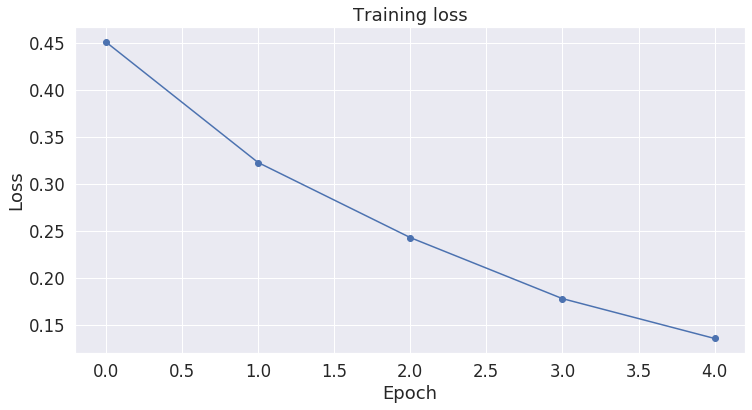

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Predict

I decided to go ahead and predict using test data from the competition. I am doing the same steps as in the previous sections on train and validation data.

In [22]:
# Load test dataset into a pandas dataframe.
test_df = pd.read_csv("/content/test.csv")

# Display the number of sentences.
print('Number of tweets in test data: {:,}\n'.format(test_df.shape[0]))

test_df[['keyword', 'location']] = test_df[['keyword', 'location']].fillna(" ")
test_df["tweets"] = test_df["text"] + " " + test_df["keyword"] + " " + test_df["location"]
test_df

Number of tweets in test data: 3,263



,id,keyword,location,text,tweets
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...,...
3258,10861,,,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,,,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My city...
3260,10868,,,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co/U...
3261,10874,,,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO) htt...


In [0]:
# Create sentence and label lists
tweets = test_df.tweets.values

# clean tweets
tweets = [clean(tweet) for tweet in tweets]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every tweet...
for tweet in tweets:
    encoded_tweet = tokenizer.encode(tweet, add_special_tokens = True)
    input_ids.append(encoded_tweet)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=max_len, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token and 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
# prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [24]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy().squeeze().tolist()
  # label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(logits)
  # true_labels.append(label_ids)

print('\n DONE.')


Predicting labels for 3,263 test sentences...

 DONE.


In [25]:
pred_labels = np.argmax(predictions, axis=1).flatten()
print(pred_labels)

[1 1 1 ... 1 1 1]


In [26]:
# just being paranoid, making sure that it's the same as the number of inputs for prediction
print(len(pred_labels))

3263


In [27]:
# get a df that is of the required format 
submission_df = pd.read_csv("/content/sample_submission.csv")
submission_df["target"] = pred_labels
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [0]:
submission_df.to_csv('/content/submission.csv', index=False)

After submitting, my score came in at 0.82413 (previously 0.80061), which puts me at the top 27% (previously 44%). Still way to go but I am seeing some improvement. :) Next step would be data augmentation. Will update this space with either a new script/notebook when I'm done. Till then. 